In [ ]:
from IPython.core import display
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import os

#If you are running on a server, launch xvfb to record game videos
#Please make sure you have xvfb installed
!sudo apt install xvfb
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

С теорией могут помочь эти слайды: http://rail.eecs.berkeley.edu/deeprlcourse-fa17/f17docs/lecture_5_actor_critic_pdf.pdf

А могут и не помочь.

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display

### Мастерами кунг-фу не рождаются

Сегодня мы будем играть в Atari [KungFuMaster](https://gym.openai.com/envs/KungFuMaster-v0/), на этот раз используя рекуррентные сетки.

![kung-fu-master](https://lh3.googleusercontent.com/fzmeaDZPcTJqlrdA_NMhXOFkafTiM5JnBxUkYdgH_FlAjoCVWYmGbxia16MwnIpu1g=w412-h220-rw)

Эта игра уже намного сложнее удержания палки в вертикальном положении. Состояние — это RGB картинка монитора (трёхмерный массив размера 210x160x3), а на выбор у вас есть целых 14 действий — разные перемещения, удары, прыжки и прочее.

In [ ]:
# убедитесь, что atari_util.py находится в той же директории,
# что и эта тетрадка, а также поставьте atari-py:
!pip install atari-py

In [ ]:
#         PLAN
# http://www.atarimania.com/rom_collection_archive_atari_2600_roms.html
#In order to import ROMS, you need to download Roms.rar from the Atari 2600 VCS ROM Collection and extract the .rar file. Once you've done that, run:

#python -m atari_py.import_roms <path to folder>"

In [ ]:
# in console: python -m atari_py.import_roms /content

In [ ]:
import gym
from atari_util import PreprocessAtari

def make_env():
    env = gym.make("KungFuMasterDeterministic-v0")
    env = PreprocessAtari(
        env, height=42, width=42,
        crop=lambda img: img[60:-30, 5:],
        dim_order='pytorch',
        color=False, n_frames=4)
    return env

env = make_env()

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

Observation shape: (4, 42, 42)
Num actions: 14
Action names: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


In [ ]:
s = env.reset()
for _ in range(100):
    s, _, _, _ = env.step(env.action_space.sample())

plt.title('Исходное изображение')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Что видит агент')
plt.imshow(s.transpose([1, 0, 2]).reshape([42, -1]), cmap='gray')
plt.show()

### Частично-наблюдаемые MDP

Наша игра — это на самом деле POMDP: агент знает тайминги, когда враги спавнятся и двигаются, но понять это по одной картинке он не может — ему нужна какая-то память для этого.

Нам нужна какая-то сеть, которая использует память рекуррентной сети. Например, такая:

<img src='https://github.com/yandexdataschool/Practical_RL/blob/spring19/week08_pomdp/img1.jpg?raw=true' width='500px'> 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# [batch, channel, w, h] -> [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
def conv2d_size_out(size, kernel_size, stride):
    return (size - (kernel_size - 1) - 1) // stride + 1

In [ ]:
class Agent(nn.Module):
    def __init__(self, input_dims, n_actions, lr):
        super(Agent, self).__init__()
        
        self.input_dims = input_dims

        
        self.l1=torch.nn.Conv2d(in_channels=4, out_channels=32, kernel_size=(3,3), stride=2)
        self.l2=torch.nn.Conv2d(in_channels=32,out_channels=32, kernel_size=(3,3), stride=2)
        self.l3=torch.nn.Conv2d(in_channels=32,out_channels=32, kernel_size=(3,3), stride=2)
        self.l4=torch.nn.Flatten()
        self.l5=torch.nn.Linear(512,128)
        self.a=torch.nn.Linear(128,n_actions)
        self.v=torch.nn.Linear(128,1)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.device = device
        self.to(self.device)
        
    def forward(self, state):

        x=self.l1(state)
        x=F.relu(x)
        x=self.l2(x)
        x=F.relu(x)
        x=self.l3(x)
        x=F.relu(x)
        x=self.l4(x)
        x=self.l5(x)
        x=F.relu(x)
        logits=self.a(x)
        state_values=self.v(x)[0]

        return logits, state_values

    def choose_action(self, observation):

        if observation.ndim == 3:
            observation = [observation]

        observation = torch.tensor(observation, dtype=torch.float32, device=device)

        logits, _ = self.forward(observation)
                
        policy = F.softmax(logits, dim=-1)

        actions = np.array([np.random.choice(len(p), p=p) for p in policy.detach().cpu().numpy()])
        return actions

In [ ]:
# тест сети

agent = Agent(input_dims=obs_shape, n_actions=n_actions, lr=1e-4)
state = env.reset()
state = torch.tensor([state], dtype=torch.float32, device=device)
logits, state_values = agent(state)

assert isinstance(logits, torch.Tensor) and len(logits.shape) == 2, \
    "test1 %s" % repr(logits)
assert isinstance(state_values, torch.Tensor) and len(state_values.shape) == 1, \
    "test2 %s" % repr(state_values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  """


# Actor Critic

In [ ]:
def compute_actor_critic_loss(agent, state, action, reward, next_state, done,
                              gamma=0.99):
 
    batch_size = state.shape[0]


    state      = torch.tensor(state, dtype=torch.float32, device=device)
    next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
    reward     = torch.tensor(reward, dtype=torch.float32, device=device)
    done       = torch.tensor(done, dtype=torch.bool, device=device)


    logits, state_value = agent(state)
    next_logits, next_state_value = agent(next_state)


    probs    = F.softmax(logits, dim=-1)     #[n_envs, n_actions]
    logprobs = F.log_softmax(logits, dim=-1) #[n_envs, n_actions]

    target_state_value = reward+gamma*next_state_value*(1-done*1)

  
    advantage = target_state_value -state_value

    
    batch_idx = np.arange(batch_size)
    logp_actions = logprobs[batch_idx, action]

    
    entropy = -torch.sum(probs*logprobs,axis=-1)

    actor_loss = -(logp_actions * advantage.detach()).mean() - 0.001 * entropy.mean()
    critic_loss = F.mse_loss(target_state_value.detach(), state_value)

    total_loss = actor_loss + critic_loss

    
    agent.optimizer.zero_grad()
    total_loss.backward()
    agent.optimizer.step()

    return actor_loss.cpu().detach().numpy(), critic_loss.cpu().detach().numpy(), entropy.cpu().detach().numpy()

In [ ]:
state = env.reset()
state = torch.tensor([state], dtype=torch.float32).to(device)
logits, value = agent(state)
print("action logits:\n", logits)
print("state values:\n", value)

action logits:
 tensor([[-0.0711, -0.0935, -0.0181,  0.0129,  0.0870,  0.0492,  0.0082,  0.0987,
         -0.0762,  0.0588,  0.0201, -0.0611,  0.0145, -0.0863]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
state values:
 tensor([-0.0653], device='cuda:0', grad_fn=<SelectBackward0>)


# Let's play!

In [ ]:
def evaluate(agent, env, n_games=1):
    game_rewards = []
    for _ in range(n_games):
        state = env.reset()

        total_reward = 0
        while True:
            action = agent.choose_action(state)
            state, reward, done, info = env.step(action)
            total_reward += reward
            if done:
                break

        game_rewards.append(total_reward)
    return game_rewards

In [ ]:
import gym.wrappers

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    rewards = evaluate(agent, env_monitor, n_games=3)

print(rewards)

[500.0, 100.0, 400.0]


# Параллельные игры

In [ ]:
class EnvBatch:
    def __init__(self, n_envs = 10):
        self.envs = [make_env() for _ in range(n_envs)]
        
    def reset(self):
        return np.array([env.reset() for env in self.envs])
    
    def step(self, actions):
      
        results = [env.step(a) for env, a in zip(self.envs, actions)]
        new_obs, rewards, done, infos = map(np.array, zip(*results))
        
        # автоматический перезапуск среды
        for i in range(len(self.envs)):
            if done[i]:
                new_obs[i] = self.envs[i].reset()
        
        return new_obs, rewards, done, infos

In [ ]:
env_batch = EnvBatch(10)

batch_states = env_batch.reset()
batch_actions = agent.choose_action(batch_states)
batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

print("State shape:", batch_states.shape)
print("Actions:", batch_actions)
print("Rewards:", batch_rewards)
print("Done:", batch_done)

State shape: (10, 4, 42, 42)
Actions: [ 1  8  7 10  6  1  2 11  3 12]
Rewards: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Done: [False False False False False False False False False False]


In [ ]:
agent = Agent(lr=1e-4, n_actions=n_actions, input_dims=obs_shape)

state = env_batch.reset()
action = agent.choose_action(state)

next_state, reward, done, info = env_batch.step(action)

l_act, l_crit, ent = compute_actor_critic_loss(agent, state, action, reward, next_state, done)
print(ent.mean(),np.log(n_actions))
assert abs(l_act) < 100 and abs(l_crit) < 100, "лоссы слишком большие"
assert 0 <= ent.mean() <= np.log(n_actions), "Нереальное значение энтропии"
if ent.mean() < np.log(n_actions) / 2:
    print("Энтропия слишком мала для нетренированного агента")
print("Ты готов!")

2.6384299 2.6390573296152584
Ты готов!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


# Обучение

In [ ]:
import pandas as pd

def ewma(x, span=100):
    return pd.DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

env_batch = EnvBatch(10)
batch_states = env_batch.reset()

rewards_history = []
entropy_history = []

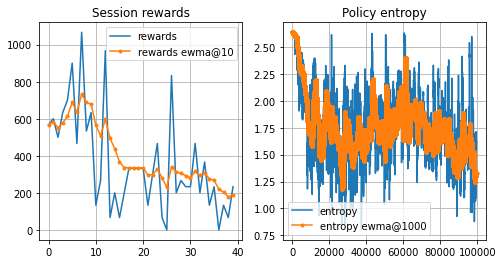

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
100%|██████████| 100000/100000 [34:09<00:00, 48.79it/s]


In [ ]:
import tqdm
from IPython.display import clear_output

with tqdm.trange(len(entropy_history), 100000) as progress_bar:
    for i in progress_bar:
        batch_actions = agent.choose_action(batch_states)
        batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

  
        batch_rewards = batch_rewards * 0.01

        agent_loss, critic_loss, entropy = compute_actor_critic_loss(
            agent, batch_states, batch_actions, batch_rewards, batch_next_states, batch_done)
        entropy_history.append(np.mean(entropy))

        batch_states = batch_next_states

        if i % 500 == 0:
            if i % 2500 == 0:
                rewards_history.append(np.mean(evaluate(agent, env, n_games=3)))
                if rewards_history[-1] >= 5000:
                    print("А ты хорош!")

            clear_output(True)

            plt.figure(figsize=[8, 4])
            plt.subplot(1, 2, 1)
            plt.plot(rewards_history, label='rewards')
            plt.plot(ewma(np.array(rewards_history), span=10), marker='.', label='rewards ewma@10')
            plt.title("Session rewards")
            plt.grid()
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(entropy_history, label='entropy')
            plt.plot(ewma(np.array(entropy_history), span=1000), marker='.', label='entropy ewma@1000')
            plt.title("Policy entropy")
            plt.grid()
            plt.legend()
            plt.show()

# Финальный результат и видосик

In [ ]:
import gym.wrappers

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    final_rewards = evaluate(agent, env_monitor, n_games=3)

print("Final mean reward:", np.mean(final_rewards))

Final mean reward: 666.6666666666666


In [ ]:
from IPython.display import Image
Image(open('videos/1.m4','rb').read())

In [ ]:
from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))